In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Сверточная нейронная сеть

In [3]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [4]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [5]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [6]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

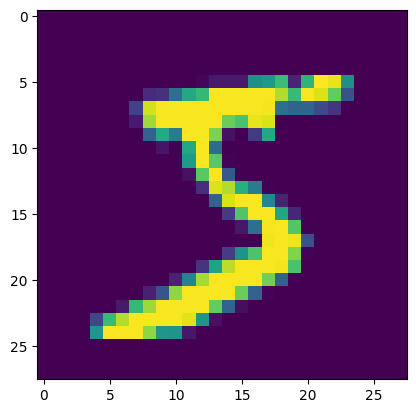

In [7]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [8]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [9]:
def train(model, optimizer, criterion=F.cross_entropy, n_epochs=5):
    losses = []
    accuracy = []
    val_epochs = []
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            y_pred = model(x_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_epochs.append(epoch)
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    x_val = x_val.to(device)
                    y_val = y_val.to(device)

                    y_pred = model(x_val)
                    loss = criterion(y_pred, y_val)
                    val_loss.append(loss.cpu().numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).cpu().numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')
            losses.append(np.mean(val_loss))
            accuracy.append(np.mean(val_accuracy))

    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax[0].plot(val_epochs, losses)
    ax[0].set_title("Test Loss")
    ax[0].set_xlabel("Epoch")

    ax[1].plot(val_epochs, accuracy)
    ax[1].set_title("Test Accuracy")
    ax[1].set_xlabel("Epoch")
    plt.show()

100%|██████████| 157/157 [00:01<00:00, 78.99it/s]


Epoch: 0, loss: 0.3203020393848419, accuracy: 0.9099


100%|██████████| 157/157 [00:01<00:00, 80.50it/s]


Epoch: 2, loss: 0.23288218677043915, accuracy: 0.9316


100%|██████████| 157/157 [00:02<00:00, 69.23it/s]


Epoch: 4, loss: 0.18695397675037384, accuracy: 0.9462


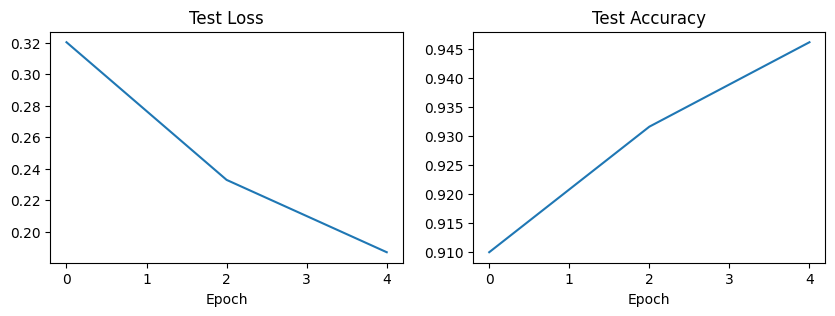

In [10]:
train(model, optimizer)

In [11]:
0.9462

0.9462

In [12]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

100%|██████████| 157/157 [00:02<00:00, 75.15it/s]


Epoch: 0, loss: 0.26602691411972046, accuracy: 0.9249


100%|██████████| 157/157 [00:02<00:00, 61.84it/s]


Epoch: 2, loss: 0.12701284885406494, accuracy: 0.9625


100%|██████████| 157/157 [00:02<00:00, 75.11it/s]


Epoch: 4, loss: 0.08627695590257645, accuracy: 0.9744


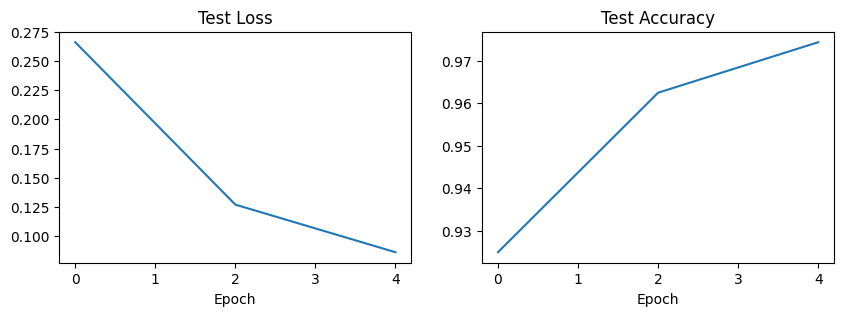

In [13]:
train(model, optimizer)

In [14]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

* В качестве оптимизатора используется Adam.<br>
* Функция ошибки - nn.MultiMarginLoss



==== PARAMETERS: out - 10, kernel_size - 4 ====



100%|██████████| 157/157 [00:02<00:00, 77.73it/s]


Epoch: 0, loss: 0.012570729479193687, accuracy: 0.9633


100%|██████████| 157/157 [00:02<00:00, 76.63it/s]


Epoch: 2, loss: 0.008962749503552914, accuracy: 0.9769


100%|██████████| 157/157 [00:02<00:00, 77.41it/s]


Epoch: 4, loss: 0.010246536694467068, accuracy: 0.9772


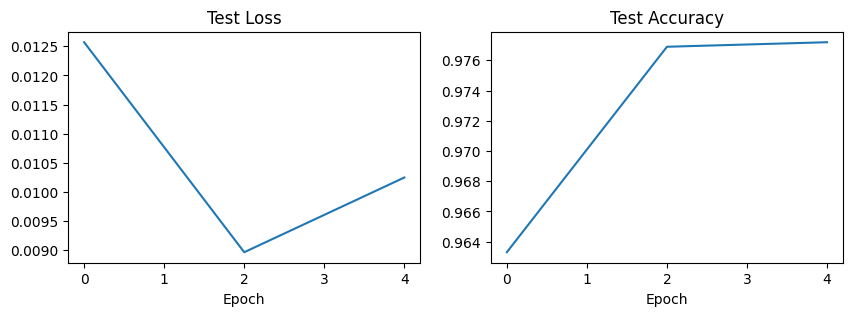

==== PARAMETERS: out - 10, kernel_size - 5 ====



100%|██████████| 157/157 [00:02<00:00, 77.50it/s]


Epoch: 0, loss: 0.009462675079703331, accuracy: 0.974


100%|██████████| 157/157 [00:02<00:00, 76.52it/s]


Epoch: 2, loss: 0.009011012502014637, accuracy: 0.9794


100%|██████████| 157/157 [00:02<00:00, 76.34it/s]


Epoch: 4, loss: 0.01703644171357155, accuracy: 0.9747


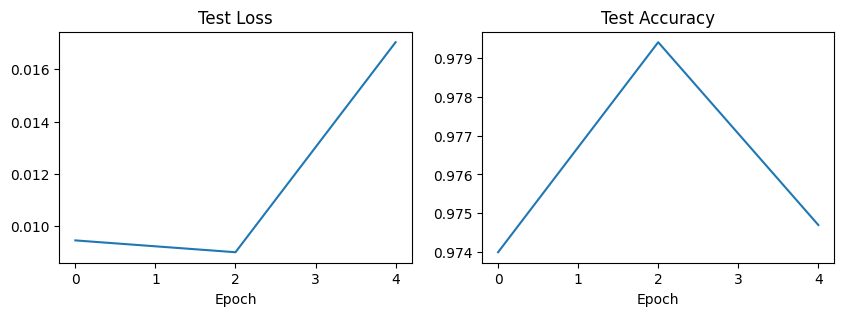

==== PARAMETERS: out - 10, kernel_size - 6 ====



100%|██████████| 157/157 [00:02<00:00, 75.48it/s]


Epoch: 0, loss: 0.011676277965307236, accuracy: 0.9688


100%|██████████| 157/157 [00:02<00:00, 71.97it/s]


Epoch: 2, loss: 0.01429575402289629, accuracy: 0.9652


100%|██████████| 157/157 [00:02<00:00, 77.14it/s]


Epoch: 4, loss: 0.016161758452653885, accuracy: 0.971


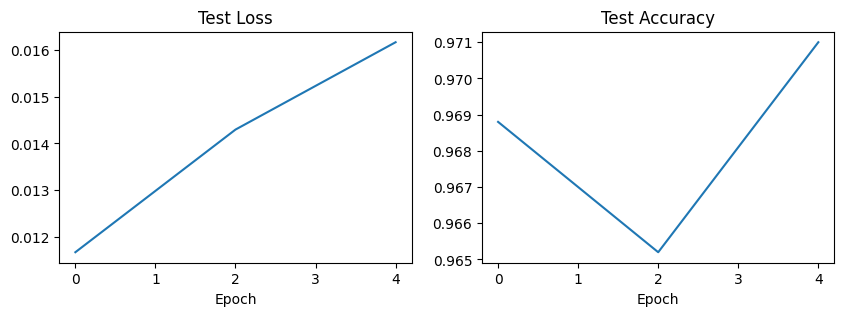

==== PARAMETERS: out - 20, kernel_size - 4 ====



100%|██████████| 157/157 [00:02<00:00, 62.11it/s]


Epoch: 0, loss: 0.010318927466869354, accuracy: 0.9751


100%|██████████| 157/157 [00:02<00:00, 76.76it/s]


Epoch: 2, loss: 0.011617669835686684, accuracy: 0.976


100%|██████████| 157/157 [00:02<00:00, 75.95it/s]


Epoch: 4, loss: 0.016494425013661385, accuracy: 0.9764


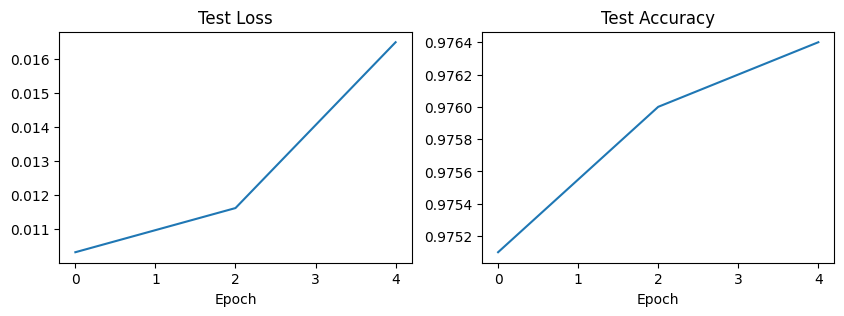

==== PARAMETERS: out - 20, kernel_size - 5 ====



100%|██████████| 157/157 [00:02<00:00, 74.55it/s]


Epoch: 0, loss: 0.008764185942709446, accuracy: 0.9757


100%|██████████| 157/157 [00:02<00:00, 65.13it/s]


Epoch: 2, loss: 0.011282450519502163, accuracy: 0.9744


100%|██████████| 157/157 [00:02<00:00, 73.57it/s]


Epoch: 4, loss: 0.010915824212133884, accuracy: 0.9788


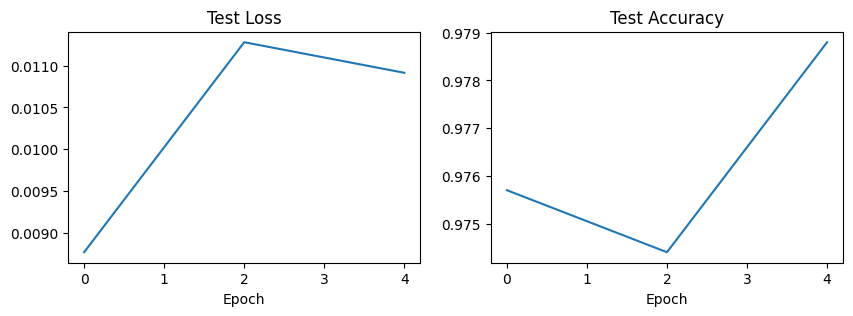

==== PARAMETERS: out - 20, kernel_size - 6 ====



100%|██████████| 157/157 [00:02<00:00, 63.97it/s]


Epoch: 0, loss: 0.011389637365937233, accuracy: 0.9703


100%|██████████| 157/157 [00:02<00:00, 74.87it/s]


Epoch: 2, loss: 0.02267506532371044, accuracy: 0.9579


100%|██████████| 157/157 [00:02<00:00, 74.56it/s]


Epoch: 4, loss: 0.012807617895305157, accuracy: 0.9786


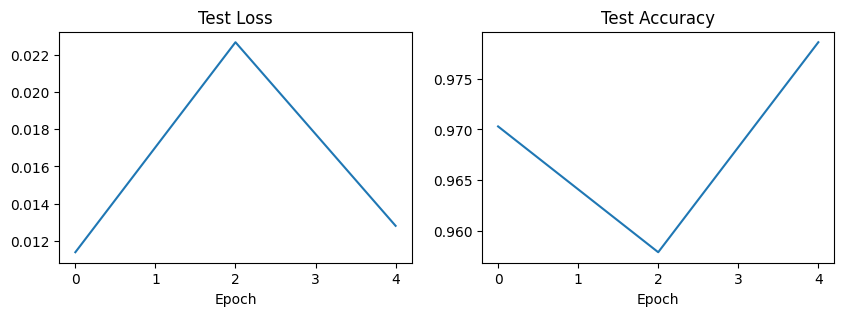

==== PARAMETERS: out - 30, kernel_size - 4 ====



100%|██████████| 157/157 [00:02<00:00, 74.75it/s]


Epoch: 0, loss: 0.008606634102761745, accuracy: 0.9769


100%|██████████| 157/157 [00:02<00:00, 74.41it/s]


Epoch: 2, loss: 0.009618975222110748, accuracy: 0.9807


100%|██████████| 157/157 [00:02<00:00, 75.12it/s]


Epoch: 4, loss: 0.011003495194017887, accuracy: 0.978


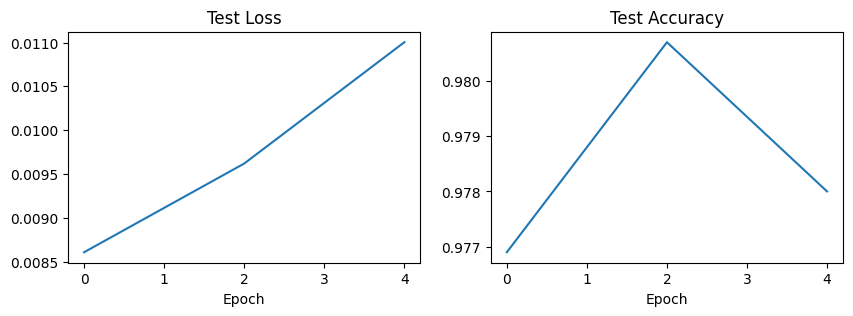

==== PARAMETERS: out - 30, kernel_size - 5 ====



100%|██████████| 157/157 [00:02<00:00, 70.79it/s]


Epoch: 0, loss: 0.00790835078805685, accuracy: 0.9778


100%|██████████| 157/157 [00:02<00:00, 68.33it/s]


Epoch: 2, loss: 0.010816880501806736, accuracy: 0.9771


100%|██████████| 157/157 [00:02<00:00, 72.30it/s]


Epoch: 4, loss: 0.015865681692957878, accuracy: 0.9702


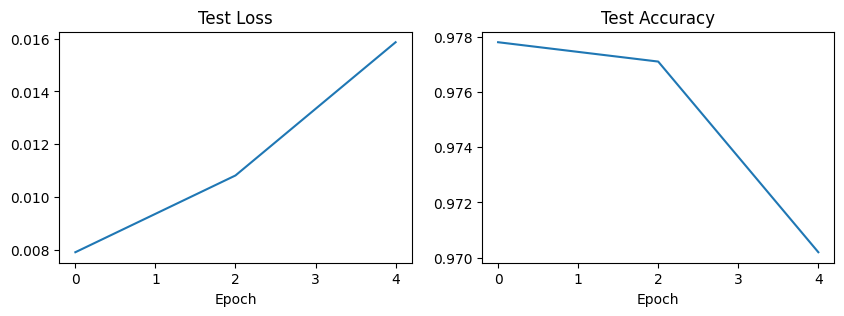

==== PARAMETERS: out - 30, kernel_size - 6 ====



100%|██████████| 157/157 [00:02<00:00, 67.29it/s]


Epoch: 0, loss: 0.009687187150120735, accuracy: 0.9747


100%|██████████| 157/157 [00:02<00:00, 71.65it/s]


Epoch: 2, loss: 0.01337791234254837, accuracy: 0.9713


100%|██████████| 157/157 [00:02<00:00, 62.98it/s]


Epoch: 4, loss: 0.020370421931147575, accuracy: 0.9764


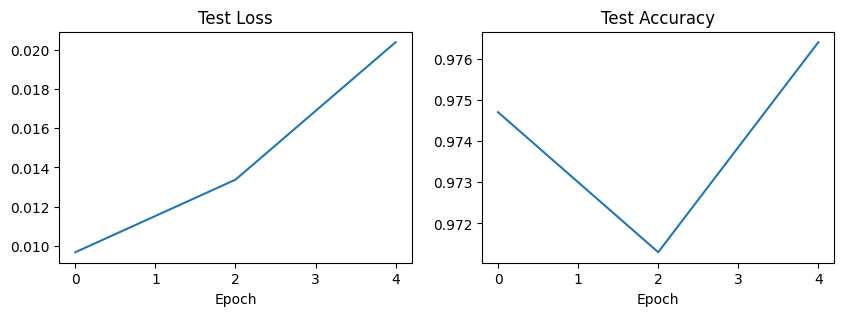

In [15]:
import itertools

outs = [10, 20, 30]
kernel_sizes = [4, 5, 6]

for out, kernel_size in itertools.product(outs, kernel_sizes):
    in_features = ((25 - kernel_size) // 4 + 1) ** 2 * out

    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=out, kernel_size=kernel_size),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(in_features, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    print(f"==== PARAMETERS: out - {out}, kernel_size - {kernel_size} ====\n")
    train(model, optimizer, criterion=nn.MultiMarginLoss())


Лучшие параметры: out - 20, kernel_size - 5
<br>
Accuracy = 0.9788

In [19]:
best_model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=4),
        nn.Flatten(),
        nn.Linear(720, 128),
        nn.ReLU(),
        nn.Linear(128, 10)
    )

number_of_parameters = sum(p.numel() for p in best_model.parameters() if p.requires_grad)
print(f"Число обучаемых параметров лучшей модели: {number_of_parameters}")

Число обучаемых параметров лучшей модели: 94098
